# Single tile prediction

In [149]:
import ee
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pprint import pprint
import folium

from PIL import Image
import requests
from io import BytesIO

## Composite
### Get tile

In [2]:
ee.Initialize()

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from preprocess import ee_collection_specifics_tile_server

**Geometry as an input**

In [507]:
# Geometry
lon = -112.3639
lat = 43.1987

# Instrument
collection = 'Sentinel2'

# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')

In [514]:
# Area of Interest
point = ee.Geometry.Point([lon, lat]).buffer(1000)
# Polygon as an input
coordinates = np.array(point.bounds().getInfo()['coordinates'][0])
bbox = [min(coordinates[:,0]), min(coordinates[:,1]), max(coordinates[:,0]), max(coordinates[:,1])]
# Rectangle
geom = ee.Geometry.Rectangle(bbox)
region = geom.bounds().getInfo()['coordinates']

In [515]:
# Bands
bands = ee_collection_specifics_tile_server.ee_bands_rgb(collection)

# Visualiztion parameters
#visParam = ee_collection_specifics_tile_server.vizz_params_rgb(collection)

In [516]:
# Image Collection
image_collection = ee_collection_specifics_tile_server.ee_collections(collection)

## Composite
image = ee_collection_specifics_tile_server.Composite(collection)(image_collection, startDate, stopDate, geom)
        
## Select bands
image_rgb = image.select(bands)

In [511]:
def tile_ThumbURL(image, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        url = image.getThumbURL(viz_params)
    else:
        url = image.getThumbURL()
    return url

In [517]:
thumb_url = tile_ThumbURL(image_rgb, {'min':visParam['min'],'max':visParam['max'], 'region': region, 'dimensions': [256,256]})

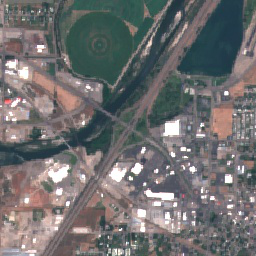

In [518]:
response = requests.get(thumb_url)
img_rgb = Image.open(BytesIO(response.content))
img_rgb

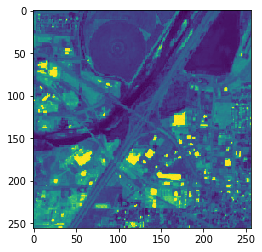

In [519]:
arr_rgb = np.array(img_rgb)
plt.imshow(arr_rgb[:,:,1])

In [520]:
def tile_url(image, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + "/{z}/{x}/{y}?token="+ d['token'])
    return url

In [522]:
tiles_rgb = tile_url(image_rgb.clip(geom), {'min':visParam['min'],'max':visParam['max']})
map = folium.Map(location=[lat, lon], zoom_start=14)
map.add_tile_layer(tiles_rgb, max_zoom=19, min_zoom=1, attr="Live EE tiles")
map

**{z}/{x}/{y} as an input**

In [ ]:
collection = 'Sentinel2'
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')

# Image Collection
image_collection = ee_collection_specifics_tile_server.ee_collections(collection)
 
# Bands
bands = ee_collection_specifics_tile_server.ee_bands_rgb(collection)
         
# Visualiztion parameters
visParam = ee_collection_specifics_tile_server.vizz_params_rgb(collection)
        
## Composite
image = ee_collection_specifics_tile_server.Composite(collection)(image_collection, startDate, stopDate)
        
## Select bands
image_rgb = image.select(bands)

**Display the results on a map**

In [ ]:
def tile_url_zxy(image, zxy, viz_params=None):
    """Create a target url for tiles for an image.
    """
    if viz_params:
        d = image.getMapId(viz_params)
    else:
        d = image.getMapId()
    base_url = 'https://earthengine.googleapis.com'
    url = (base_url + '/map/' + d['mapid'] + "/{}/{}/{}?token=".format(zxy[0],zxy[1],zxy[2]) + d['token'])
    return url

In [ ]:
zxy = [13,4022,3010]#[13,1352,3178]
tile_rgb = tile_url_zxy(image_rgb, zxy, {'min':visParam['min'],'max':visParam['max']})
tile_rgb

In [ ]:
response = requests.get(tile_rgb)
img_rgb = Image.open(BytesIO(response.content))
img_rgb

In [ ]:
arr_rgb = np.array(img_rgb)
plt.imshow(arr_rgb[:,:,1])

### Requesting predictions

In [153]:
from google.oauth2 import service_account
from googleapiclient import discovery

def predict_json(project, model, instances, privatekey_path, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """    
    # To authenticate set the GOOGLE_APPLICATION_CREDENTIALS
    credentials = service_account.Credentials.from_service_account_file(privatekey_path)
    
    # Create the AI Platform service object.
    service = discovery.build('ml', 'v1', credentials=credentials)
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [523]:
data = np.around(arr_rgb/255,2).tolist()
instance = {"image" : data}

In [555]:
PROJECT_ID = "skydipper-196010"
MODEL_NAME = "deepvel"
MODEL_VERSION = "v3"
privatekey_path = '/Users/ikersanchez/Vizzuality/Keys/Skydipper/skydipper-a7dd533b1f5e.json'
response = predict_json(project=PROJECT_ID, model=MODEL_NAME, instances=instance, privatekey_path=privatekey_path, version=MODEL_VERSION)

In [525]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

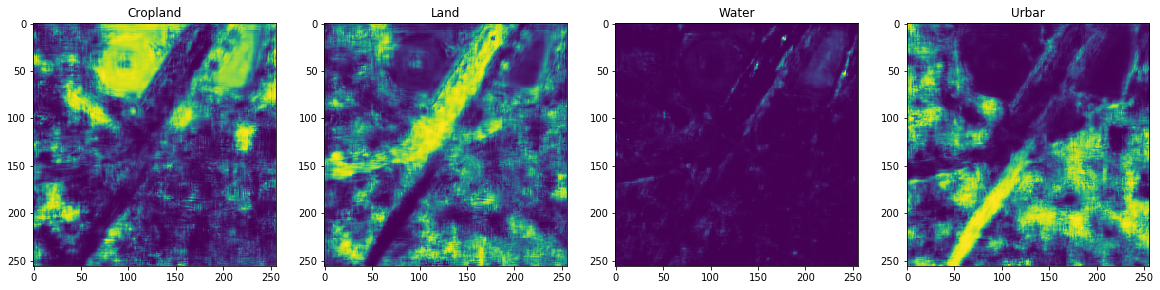

In [556]:
output = np.array(response[0].get('output'))
output.shape
display_channels(output, output.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

We binarize the output taking the highest pixel value

In [527]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

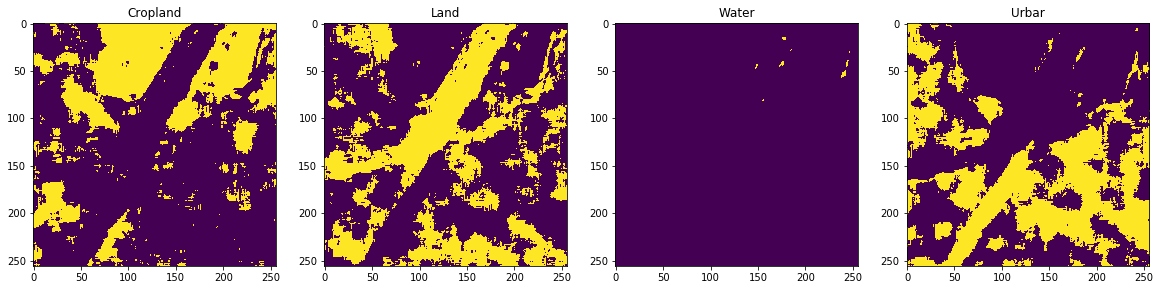

In [557]:
output_classification = max_pixels(output)
display_channels(output_classification, output_classification.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

### Display Segmentation¶

In [529]:
def channelnorm(im, channels, vmin, vmax):
    for channel in channels:
        c = (im[:,:,channel]-vmin) / (vmax-vmin)
        c[c<0.] = 0
        c[c>1.] = 1
        im[:,:,channel] = c
    return im

In [558]:
# Predicted image
output_segnet = np.copy(output_classification)
output_segnet = np.argmax(output_segnet, axis=2)
dim = output_segnet.shape

(-0.5, 255.5, 255.5, -0.5)

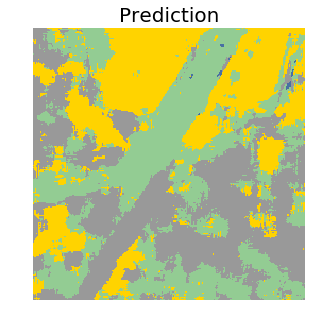

In [559]:
fig, ax = plt.subplots(figsize=(5,5))

colors_dic = {'0':'#ffd300', '1':'#93cc93', '2':'#4970a3', '3':'#999999'}

keys = list(np.unique(output_segnet))
keys = [str(i) for i in keys]
colors = [colors_dic.get(key) for key in keys]

cmap = mpl.colors.ListedColormap(colors)

ax.imshow(output_segnet, cmap=cmap)
ax.set_title('Prediction', fontsize=20)
ax.axis('off')

### Get Segmented image as a numpy array¶

In [560]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def segmented_image(arr):
    
    colors_dic = {'0':'#ffd300', '1':'#93cc93', '2':'#4970a3', '3':'#999999'}

    keys = list(np.unique(arr))
    keys = [str(i) for i in keys]
    colors = [colors_dic.get(key) for key in keys]
    
    cmap = mpl.colors.ListedColormap(colors)

    fig = Figure()
    fig.set_size_inches(256/fig.get_dpi(), 256/fig.get_dpi())
    fig.subplots_adjust(0,0,1,1)
    canvas = FigureCanvas(fig)
    ax = fig.gca()

    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

    ax.imshow(arr, cmap=cmap)
    ax.axis('off')
    ax.margins(0,0)

    canvas.draw()       # draw the canvas, cache the renderer

    width, height = fig.get_size_inches() * fig.get_dpi()

    image = np.fromstring(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    
    return image

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


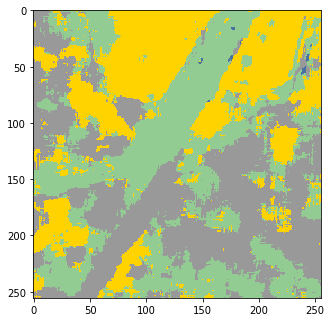

In [561]:
image = segmented_image(output_segnet)
plt.imshow(image)

### Show the raster on an OpenStreetMap map

In [ ]:
import math

class GlobalMercator(object):
    """
    TMS Global Mercator Profile
    ---------------------------
    Functions necessary for generation of tiles in Spherical Mercator projection,
    EPSG:900913 (EPSG:gOOglE, Google Maps Global Mercator), EPSG:3785, OSGEO:41001.
    Such tiles are compatible with Google Maps, Microsoft Virtual Earth, Yahoo Maps,
    UK Ordnance Survey OpenSpace API, ...
    and you can overlay them on top of base maps of those web mapping applications.
    
    Pixel and tile coordinates are in TMS notation (origin [0,0] in bottom-left).
    What coordinate conversions do we need for TMS Global Mercator tiles::
         LatLon      <->       Meters      <->     Pixels    <->       Tile     
     WGS84 coordinates   Spherical Mercator  Pixels in pyramid  Tiles in pyramid
         lat/lon            XY in metres     XY pixels Z zoom      XYZ from TMS 
        EPSG:4326           EPSG:900913                                         
         .----.              ---------               --                TMS      
        /      \     <->     |       |     <->     /----/    <->      Google    
        \      /             |       |           /--------/          QuadTree   
         -----               ---------         /------------/                   
       KML, public         WebMapService         Web Clients      TileMapService
    What is the coordinate extent of Earth in EPSG:900913?
      [-20037508.342789244, -20037508.342789244, 20037508.342789244, 20037508.342789244]
      Constant 20037508.342789244 comes from the circumference of the Earth in meters,
      which is 40 thousand kilometers, the coordinate origin is in the middle of extent.
      In fact you can calculate the constant as: 2 * math.pi * 6378137 / 2.0
      $ echo 180 85 | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:900913
      Polar areas with abs(latitude) bigger then 85.05112878 are clipped off.
    What are zoom level constants (pixels/meter) for pyramid with EPSG:900913?
      whole region is on top of pyramid (zoom=0) covered by 256x256 pixels tile,
      every lower zoom level resolution is always divided by two
      initialResolution = 20037508.342789244 * 2 / 256 = 156543.03392804062
    What is the difference between TMS and Google Maps/QuadTree tile name convention?
      The tile raster itself is the same (equal extent, projection, pixel size),
      there is just different identification of the same raster tile.
      Tiles in TMS are counted from [0,0] in the bottom-left corner, id is XYZ.
      Google placed the origin [0,0] to the top-left corner, reference is XYZ.
      Microsoft is referencing tiles by a QuadTree name, defined on the website:
      http://msdn2.microsoft.com/en-us/library/bb259689.aspx
    The lat/lon coordinates are using WGS84 datum, yeh?
      Yes, all lat/lon we are mentioning should use WGS84 Geodetic Datum.
      Well, the web clients like Google Maps are projecting those coordinates by
      Spherical Mercator, so in fact lat/lon coordinates on sphere are treated as if
      the were on the WGS84 ellipsoid.
     
      From MSDN documentation:
      To simplify the calculations, we use the spherical form of projection, not
      the ellipsoidal form. Since the projection is used only for map display,
      and not for displaying numeric coordinates, we don't need the extra precision
      of an ellipsoidal projection. The spherical projection causes approximately
      0.33 percent scale distortion in the Y direction, which is not visually noticable.
    How do I create a raster in EPSG:900913 and convert coordinates with PROJ.4?
      You can use standard GIS tools like gdalwarp, cs2cs or gdaltransform.
      All of the tools supports -t_srs 'epsg:900913'.
      For other GIS programs check the exact definition of the projection:
      More info at http://spatialreference.org/ref/user/google-projection/
      The same projection is degined as EPSG:3785. WKT definition is in the official
      EPSG database.
      Proj4 Text:
        +proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0
        +k=1.0 +units=m +nadgrids=@null +no_defs
      Human readable WKT format of EPGS:900913:
         PROJCS["Google Maps Global Mercator",
             GEOGCS["WGS 84",
                 DATUM["WGS_1984",
                     SPHEROID["WGS 84",6378137,298.2572235630016,
                         AUTHORITY["EPSG","7030"]],
                     AUTHORITY["EPSG","6326"]],
                 PRIMEM["Greenwich",0],
                 UNIT["degree",0.0174532925199433],
                 AUTHORITY["EPSG","4326"]],
             PROJECTION["Mercator_1SP"],
             PARAMETER["central_meridian",0],
             PARAMETER["scale_factor",1],
             PARAMETER["false_easting",0],
             PARAMETER["false_northing",0],
             UNIT["metre",1,
                 AUTHORITY["EPSG","9001"]]]
    """
    
    def __init__(self, tileSize=256):
        "Initialize the TMS Global Mercator pyramid"
        self.tileSize = tileSize
        self.initialResolution = 2 * math.pi * 6378137 / self.tileSize
        # 156543.03392804062 for tileSize 256 pixels
        self.originShift = 2 * math.pi * 6378137 / 2.0
        # 20037508.342789244
        
    def MetersToLatLon(self, mx, my ):
        "Converts XY point from Spherical Mercator EPSG:900913 to lat/lon in WGS84 Datum"

        lon = (mx / self.originShift) * 180.0
        lat = (my / self.originShift) * 180.0

        lat = 180 / math.pi * (2 * math.atan( math.exp( lat * math.pi / 180.0)) - math.pi / 2.0)
        return lat, lon

    def Resolution(self, zoom ):
        "Resolution (meters/pixel) for given zoom level (measured at Equator)"
        
        # return (2 * math.pi * 6378137) / (self.tileSize * 2**zoom)
        return self.initialResolution / (2**zoom)
        
    def PixelsToMeters(self, px, py, zoom):
        "Converts pixel coordinates in given zoom level of pyramid to EPSG:900913"

        res = self.Resolution( zoom )
        mx = px * res - self.originShift
        my = py * res - self.originShift
        return mx, my
        

    def TileBounds(self, tx, ty, zoom):
        "Returns bounds of the given tile in EPSG:900913 coordinates"
        
        minx, miny = self.PixelsToMeters( tx*self.tileSize, ty*self.tileSize, zoom )
        maxx, maxy = self.PixelsToMeters( (tx+1)*self.tileSize, (ty+1)*self.tileSize, zoom )
        return ( minx, miny, maxx, maxy )
        
    def TileLonLatBounds(self, tx, ty, zoom ):
        "Returns bounds of the given tile in latutude/longitude using WGS84 datum"

        bounds = self.TileBounds( tx, ty, zoom)
        minLat, minLon = self.MetersToLatLon(bounds[0], bounds[1])
        maxLat, maxLon = self.MetersToLatLon(bounds[2], bounds[3])
         
        return ( minLon, minLat, maxLon, maxLat )
    
    def GoogleTile(self, tx, ty, zoom):
        "Converts TMS tile coordinates to Google Tile coordinates and vice versa"
        
        # coordinate origin is moved from bottom-left to top-left corner of the extent
        return tx, (2**zoom - 1) - ty

In [ ]:
# {z}/{x}/{y} as an input
GM = GlobalMercator()
xy = GM.GoogleTile(zxy[1],zxy[2],zxy[0])
bbox = list(GM.TileLonLatBounds(xy[0], xy[1],13))

In [185]:
# Geometry as an input
coordinates = np.array(region[0])
bbox = [min(coordinates[:,0]), min(coordinates[:,1]), max(coordinates[:,0]), max(coordinates[:,1])]

In [186]:
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
map = folium.Map(location=[mean_lat,mean_lng],zoom_start=12)


image_overlay = folium.raster_layers.ImageOverlay(image,[[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
map.add_child(image_overlay)
map

# Image

In [ ]:
source = 'LANDSAT/LC08/C01/T1_RT_TOA/LC08_172071_20180821'
band_viz = {'bands': ['B4', 'B3', 'B2'], 'min': 0.0, 'max': 0.3}

In [ ]:
collection = source.split("/")[0]

img = ee.Image(source).visualize(**band_viz)
info = img.getInfo()
coordinates = np.array(info.get('properties').get('system:footprint').get('coordinates'))

#Get tile
if collection == 'COPERNICUS':
    img = ee.Image(source).divide(10000).visualize(**band_viz)
    tile_rgb = img.getThumbUrl({'dimensions':[256,256]})
else:
    tile_rgb = img.getThumbUrl({'dimensions':[256,256]})

In [ ]:
response = requests.get(tile_rgb)
img_rgb = Image.open(BytesIO(response.content))
img_rgb

In [ ]:
arr_rgb = np.array(img_rgb)[:,:,:3]
plt.imshow(arr_rgb[:,:,1])

In [ ]:
data = np.around(arr_rgb/255,2).tolist()
instance = {"image" : data}

In [ ]:
PROJECT_ID = "skydipper-196010"
MODEL_NAME = "segnet"
MODEL_VERSION = "v1"
response = predict_json(project=PROJECT_ID, model=MODEL_NAME, instances=instance, privatekey_path=privatekey_path, version=MODEL_VERSION)

In [ ]:
output = np.array(response[0].get('output'))
display_channels(output, output.shape[2], titles=['Cropland', 'Land', 'Water', 'Urbar'])

In [ ]:
# Predicted image
output_classification = max_pixels(output)
output_segnet = np.copy(output_classification)
output_segnet = np.argmax(output_segnet, axis=2)

In [ ]:
image = segmented_image(output_segnet)
plt.imshow(image)

In [ ]:
bbox = [min(coordinates[:,0]), min(coordinates[:,1]), max(coordinates[:,0]), max(coordinates[:,1])]

In [ ]:
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
map = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)


image_overlay = folium.raster_layers.ImageOverlay(image,[[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
map.add_child(image_overlay)
map

# Cloud Functions

## Composite

In [313]:
import json
import requests

In [568]:
payload =   {'instrument': 'Sentinel2',
  'lon': -112.3639,
  'lat': 43.1987,
  'start': '2016-01-01',
  'end': '2016-12-31'}

In [569]:
url = f'https://us-central1-skydipper-196010.cloudfunctions.net/composite'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
composite = r.json()

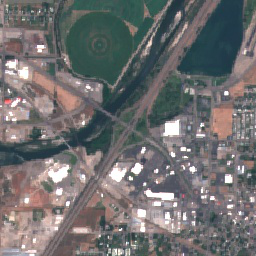

In [571]:
response = requests.get(composite.get('thumb_url'))
img_rgb = Image.open(BytesIO(response.content))
img_rgb

In [588]:
bbox = composite.get('bbox')
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
map = folium.Map(location=[mean_lat,mean_lng],zoom_start=14)
map.add_tile_layer(composite.get('tile_url'), max_zoom=19, min_zoom=1, attr="Live EE tiles")
map

## Classify

In [585]:
payload = {'thumb_url': composite.get('thumb_url'),
  'model_name': "segnet",
  'model_version': "v1"}

In [586]:
url = f'https://us-central1-skydipper-196010.cloudfunctions.net/classify'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
classify = r.json()

In [587]:
image = np.array(classify.get('output'))
bbox = composite.get('bbox')

In [584]:
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
map = folium.Map(location=[mean_lat,mean_lng],zoom_start=14)

image_overlay = folium.raster_layers.ImageOverlay(image,[[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
map.add_child(image_overlay)
map

## Segmentate

In [187]:
payload =   {'instrument': 'Sentinel-2A',
  'date_time': '2018-08-28 07:56:11Z',
  'cloud_score': 0,
  'source': 'COPERNICUS/S2/20180828T075611_20180828T082423_T35LPC',
  'band_viz': {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}}

In [189]:
import json

In [190]:
url = f'https://us-central1-skydipper-196010.cloudfunctions.net/segmentate'

headers = {'Content-Type': 'application/json'}

r = requests.post(url, data=json.dumps(payload), headers=headers)
data = r.json()

In [191]:
image = np.array(data.get('output'))
bbox = data.get('bbox')

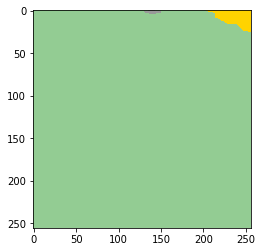

In [192]:
plt.imshow(image)

In [193]:
mean_lat = (bbox[1] + bbox[3]) / 2.0
mean_lng = (bbox[0] + bbox[2]) / 2.0
map = folium.Map(location=[mean_lat,mean_lng],zoom_start=8)


image_overlay = folium.raster_layers.ImageOverlay(image,[[bbox[1], bbox[0]], [bbox[3], bbox[2]]])
map.add_child(image_overlay)
map